# Глубинное обучение 1 / Введение в глубинное обучение, ФКН ВШЭ

## Домашнее задание 3: RNN и языковые модели

### Общая информация

Оценка после штрафа после мягкого дедлайна вычисляется по формуле $M_{\text{penalty}} = M_{\text{full}} \cdot 0.85^{t/1440}$, где $M_{\text{full}}$ — полная оценка за работу без учета штрафа, а $t$ — время в минутах, прошедшее после мягкого дедлайна (округление до двух цифр после запятой). Таким образом, спустя первые сутки после мягкого дедлайна вы не можете получить оценку выше 12.75, а если сдать через четыре дня после мягкого дедлайна, то ваш максимум — 7.83 балла.

### Оценивание и штрафы

Максимально допустимая оценка за работу — 15 баллов. Сдавать задание после указанного срока сдачи нельзя.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке. Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

### О задании

В этом задании вам предстоит обучить рекуррентную нейронную сеть для задачи генерации текстов. В качестве данных возьмем набор из 120 тысяч анекдотов (всех категорий от А до Я включительно). Его вы можете найти в архиве `jokes.txt.zip`, который доступен по [ссылке](https://disk.yandex.com/d/fjt5xICH-ukEEA).

In [7]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Задание 1: Dataset (1 балл)

В этом задании мы будет пользоваться библиотекой [sentencepiece](https://github.com/google/sentencepiece), которая поддерживает разные форматы токенизации текстов, в том числе BPE, который мы и будем использовать. Реализуйте недостающие фрагменты кода в классе `TextDataset` в файле `dataset.py`. Датасет обучает sentencepiece токенизатор, токенизирует тексты, превращает токены в индексы и паддит до одной и той же длины (параметр `max_length`). Не забудьте, что для генерации текстов нам будут нужны специальные токены начала и конца последовательности, соответственно `BOS` и `EOS`. Существуют еще два специальных токена &mdash; паддинг `PAD` и токен `UNK`, заменяющий out-of-vocabulary токены.

In [8]:
!pip install sentencepiece

In [9]:
import torch
import numpy as np

In [10]:
from dataset import TextDataset

In [11]:
train_set = TextDataset(data_file='jokes.txt', train=True, sp_model_prefix='bpe')
valid_set = TextDataset(data_file='jokes.txt', train=False, sp_model_prefix='bpe')

In [12]:
# Код должен проходить тесты
assert len(train_set) + len(valid_set) == 120759

for _ in range(5):
    for dataset in (train_set, valid_set):
        indices, length = dataset[np.random.randint(len(dataset))]
        assert indices.shape == (dataset.max_length, )
        assert indices[0].item() == dataset.bos_id
        assert (indices == dataset.eos_id).sum().item() == 1

        eos_pos = indices.tolist().index(dataset.eos_id)
        assert torch.all(indices[eos_pos + 1:] == dataset.pad_id)
        assert (indices != dataset.pad_id).sum() == length

## Задание 2 Language model (3.5 балла)

Реализуйте класс `LanguageModel` из файла `model.py`. Мы будем генерировать текст с помощью языковой модели &mdash; это авторегрессионная вероятностная модель, которая предсказывает распределение следующего токена при условии предыдущих:

$$
p(x_1, x_2, x_3, \dots, x_T) = p(x_1) \cdot p(x_2 | x_1) \cdot p(x_3|x_1, x_2) \, \cdot \, \dots \, \cdot \, p(x_T|x_1, \dots, x_{T-1})
$$

Мы будем реализовывать ее с помощью рекуррентной нейронной сети. Ваш код должен поддерживать возможность работать как с оригинальной [RNN](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html#torch.nn.RNN), так и c [LSTM](https://bitly.com/98K8eH). На каждом временном шаге модель возвращает логиты вероятностей для следующего токена. Модель будет работать в двух режимах (не путать с `.train()` и `.eval()`):

- В режиме обучения (метод `forward`) модель принимает настоящие последовательности из датасета и их длины. На каждом временном шаге возвращаются логиты вероятностей следующего токена, что позволяет считать лосс, обучаться на трейне и валидироваться на валидации.

- В режиме генерации (инференса, метод `inference`) модель принимает некоторый префикс (возможно пустой), с которого начинать генерацию, и продолжает его. Для этого на каждом шаге генерируются новые логиты, семплируется новый токен (из распределения, заданного логитами), и процесс продолжается, пока не будет сгенерирован токен `EOS` или не будет достигнуто ограничение на длину последовательности. **Обратите внимание**, что вам не нужно прогонять всю последовательность заново через RNN после каждого нового токена, это приведет к квадратичной сложности по длине последовательности. Вам достаточно обновлять скрытое состояние, подавая на вход новый сгенерированный токен и предыдущее скрытое состояние. Кроме того, чтобы получить больше контроля над генерацией, вводится параметр температуры `temp`. Перед семплированием нужно разделить на него логиты, полученные моделью.

In [13]:
from model import LanguageModel

In [14]:
model = LanguageModel(train_set)

In [15]:
# Код должен проходить тесты
for bs in [1, 4, 16, 64, 256]:
    indices = torch.randint(high=train_set.vocab_size, size=(bs, train_set.max_length))
    lengths = torch.randint(low=1, high=train_set.max_length + 1, size=(bs, ))
    logits = model(indices, lengths)
    assert logits.shape == (bs, lengths.max(), train_set.vocab_size)

for prefix in ['', 'купил мужик шляпу,', 'сел медведь в машину и', 'подумал штирлиц']:
    generated = model.inference(prefix, temp=np.random.uniform(0.1, 10))
    assert type(generated) == str
    assert generated.startswith(prefix)

## Задание 3: Training (2 балла)

Всё, что нам осталось &mdash; реализовать цикл обучения. Заполните пропуски в файле `train.py`. Не забудьте, что мы учим модель предсказывать вероятность следующего, а не текущего токена. Также рекомендуется обрезать батч индексов по самой длинной последовательности, чтобы не гонять паддинги вхолостую. Для оценки качества генерации будем использовать метрику [perplexity](https://towardsdatascience.com/perplexity-in-language-models-87a196019a94). Реализуйте ее подсчет в функции `plot_losses` (да, для этого достаточно только значения лосса).

Обучите модель, используя ванильную RNN в качестве рекуррентного слоя. Сохраните чекпойнт обученной модели, он нам еще пригодится.

In [ ]:
# YOUR CODE HERE (⊃｡•́‿•̀｡)⊃━✿✿✿✿✿✿

In [16]:
from torch import nn
from torch.utils.data import DataLoader
from train import train

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [17]:
model = LanguageModel(train_set, rnn_type=nn.RNN).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [18]:
train_set.max_length = 350
valid_set.max_length = 350

train_loader=DataLoader(train_set, num_workers=2, shuffle=False, batch_size=128)
valid_loader=DataLoader(valid_set, num_workers=2, shuffle=False, batch_size=128)

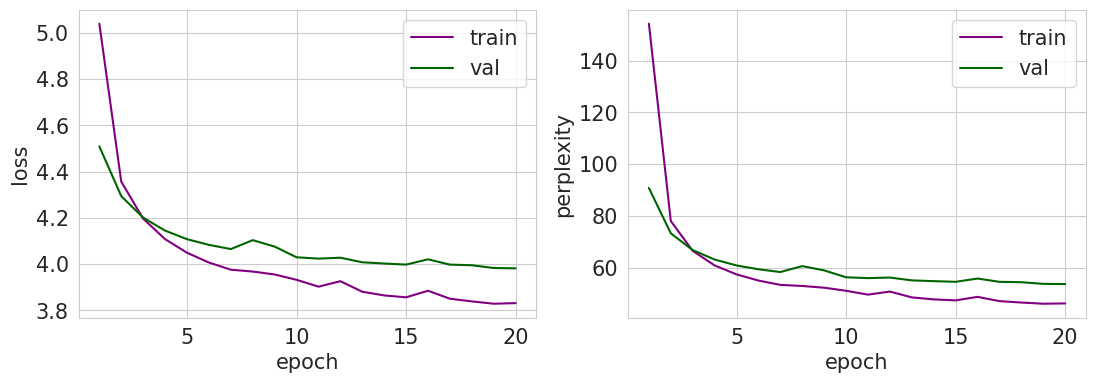

Generation examples:
отчитали природой. охева, есть то, что вдоволь кошельке, и навстречу ему- звали заключение помогает состокана.- ну и что, выписывал?
- ты еще такой и мото...- а а как хлебо что видеть нормально?- а вот за последние?- функция!
если русский человек не может считать осторожно, ушла кот.
маленький смотрит на медленно обязательно всегда его проплакатые, скрывая с шурой.
при астроной россии не мечтал еще немным, главный вниз - места, ни один чуть обоймутчину.


In [19]:
train(
    model=model,
    optimizer=optimizer,
    scheduler=None,
    train_loader=train_loader,
    val_loader=valid_loader,
    num_epochs=20,
    num_examples=5
)

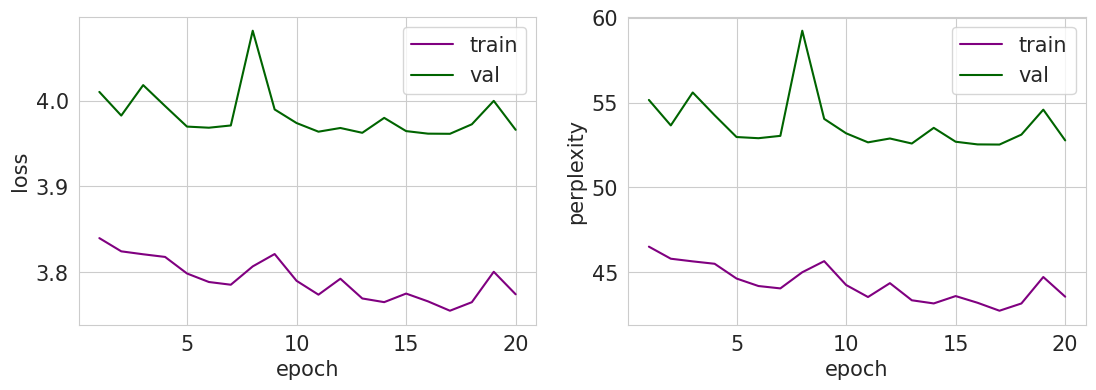

Generation examples:
- можно отгнался!
чукча притяжения.
бежал сохрами, а я терпнул себе.- что?
жена улостная вдоль жизни. кто будет прозвать скоро с дырок!
если грибы и говорит- я такое кеверный возраст?- не подсажих на снегуроль решены.


In [20]:
train(
    model=model,
    optimizer=optimizer,
    scheduler=None,
    train_loader=train_loader,
    val_loader=valid_loader,
    num_epochs=20,
    num_examples=5
)

In [21]:
torch.save(
    {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    },
    'rnn_model.pt'
)

## Задание 4: LSTM (0.5 балла)

Обучите аналогичную модель, но с LSTM в качестве рекуррентного слоя. Сравните модели по метрикам и генерации. Не забывайте про чекпойнты!

In [22]:
# YOUR CODE HERE (⊃｡•́‿•̀｡)⊃━✿✿✿✿✿✿

In [23]:
model = LanguageModel(train_set, rnn_type=nn.LSTM).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

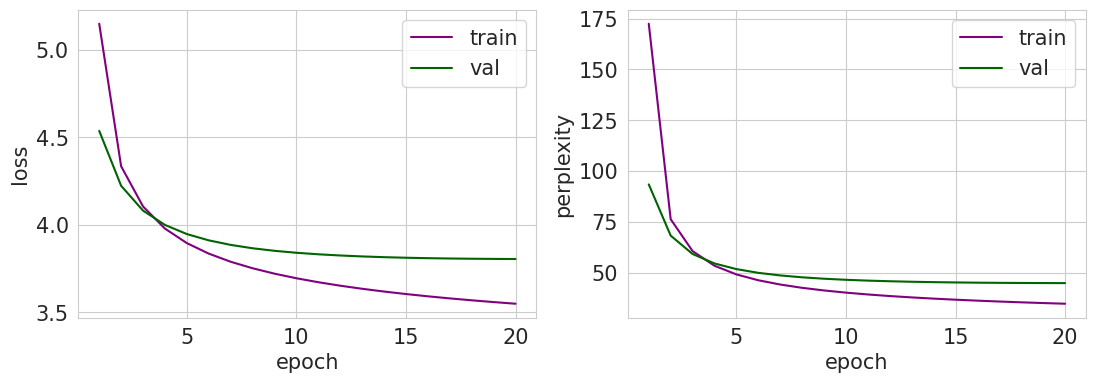

Generation examples:
любовь - это никогда не ахрен.
печень номера.
- нет, но им возникает, что только заранее.
- маленький зеркала.
читали новое недостаток, и вроде бывший, если у пацана в деревьев немного разрешила.


In [24]:
train(
    model=model,
    optimizer=optimizer,
    scheduler=None,
    train_loader=train_loader,
    val_loader=valid_loader,
    num_epochs=20,
    num_examples=5
)

In [25]:
torch.save(
    {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    },
    'lstm_model.pt'
)

## Задание 5: Sampling temperature (0.5 балла)

Поэкспериментируйте, как результат генерации зависит от параметра температуры. Попробуйте генерацию с разными префиксами. Сделайте выводы.

In [ ]:
# YOUR CODE HERE (⊃｡•́‿•̀｡)⊃━✿✿✿✿✿✿

In [26]:
state_rnn = torch.load('rnn_model.pt')

model_rnn = LanguageModel(train_set, rnn_type=nn.RNN).to(device)
model_rnn.load_state_dict(state_rnn['model_state_dict'])

<ipython-input-26-e0cc1a10bec2>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_rnn = torch.load('rnn_model.pt')


<All keys matched successfully>

In [27]:
state_lstm = torch.load('lstm_model.pt')

model_lstm = LanguageModel(train_set, rnn_type=nn.LSTM).to(device)
model_lstm.load_state_dict(state_lstm['model_state_dict'])

<ipython-input-27-9c30003663e0>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_lstm = torch.load('lstm_model.pt')


<All keys matched successfully>

Пробуем 0.1, 0.2, 2.0 и 10.0

In [28]:
num_examples = 5
for temp in [0.1, 0.3, 0.5, 0.7, 1, 1.5, 2, 5, 10]:
    print('Temperature: %.1f' % temp)
    print('RNN:')
    for _ in range(num_examples):
        print(model_rnn.inference(temp=temp))
    print('LSTM:')
    for _ in range(num_examples):
        print(model_lstm.inference(temp=temp))
    print('_______________________________')

Temperature: 0.1
RNN:
- как ты думаешь, что я не могу, чтобы у тебя на работу.
- как ты думаешь, что я не могу, чтобы не было.
- как это у вас в жизни?- нет, я не могу, чтобы я не знаю, что ты не знаешь, что я не знаю, что я не знаю, что я не могу, чтобы не выдержала.
- как ты думаешь, что я не могу, чтобы не было.
- как ты думаешь, что я не могу, чтобы не было.
LSTM:
- это невозможно, а не на что.
- в россии, когда в россии появилось, что в них независимые.
- как у вас на работе?- нет, я не могу.
- в россии - это когда ты не смог бы выполнять.
- в россии, когда у вас есть вкусные?
_______________________________
Temperature: 0.3
RNN:
- я тут в детстве, а ты не знаешь, что они не заплатят.
- а я вчера в наше время, когда я не знаю, что он не сможет, а потом задницам.
- а ты знаешь, что ты не знаешь, что ты меня любишь?- нет, я знаю, что я не знал, что я не знаю, что вы, что в ней не хватает денег.
- как ты думаешь, что я не могу, я не могу.
- как дела?- да, я не могу, а ты не нашли.
LS

Темпа 0.7 кажется самой адекватной, пробую её с разными префиксами

In [29]:
num_examples = 5
for prefix in ['штирлиц', 'в дверь постучали', 'счастье', 'деньги', 'бомж']:
    print('Prefix: %s' % prefix)
    print('RNN:')
    for _ in range(num_examples):
        print(model_rnn.inference(prefix=prefix, temp=0.7))
    print('LSTM:')
    for _ in range(num_examples):
        print(model_lstm.inference(prefix=prefix, temp=0.7))
    print('_______________________________')

Prefix: штирлиц
RNN:
штирлиц шел по улице.
штирлиц шел с женой, но она не поймешь, что он не купишь!
штирлиц зашел в результате новенье.
штирлиц пришел домой, а то ты не видел, мы друг друга.
штирлиц вышел по имени два группанец.
LSTM:
штирлиц прочитал на прошлой жизни.
штирлиц бросил.
штирлиц и не выходят домашнюю тысячу рублей.мужик- я тебе, конечно, ты же не гей!
штирлиц выстрелил.
штирлиц шелковока.
_______________________________
Prefix: в дверь постучали
RNN:
в дверь постучали задом.
в дверь постучали перед нейтрашкой.
в дверь постучали из-за друга и снизил меня на работу, на котором приставания сверху, находясь с возрастом рассчитывать весьма и пистолет.
в дверь постучали, а улетают на людей, у меня хоть какая-то.
в дверь постучали, что он ей говорит, что ты собирается пить на дом.
LSTM:
в дверь постучали. в стыке - спрашивает- что такое?- я приговоил своей жене три мужика, а девушка.
в дверь постучали, забирал в больницу. впереди- мама, папа, я беременна.- ну и что! я ему весна

В итоге видим, что темпа сильно изменяет генерацию текста. Температура контролирует случайность предсказания через изменение логитов. При делении логиты на положительный коэффициент меньший 1 (темпа), мы увеличиваем абсолютное значение выхода. То есть добавляем  генерации консервативности. Это можно заметить и по схожести результатов, например, при 0.1: все анектоды начинаются одинаково и сами они довольно короткие. Обратная ситуация приводит к большему разнообразию в генерации и соответсвено ошибок. На 1.5 модель выдаёт полный сюр...

## Задание 5: Tokenizers (1 балл)

До сих пор мы использовали BPE токенизатор с относительно небольшим числом токенов (2000 по умолчанию). Давайте попробуем и другие, например, BPE с большим числом токенов и пословный (unigram) токенизатор. Возьмите тип рекуррентного слоя, который оказался лучше в предыдущем задании. Обучите модели на таких токенизаторах и сравните их генерацию. Не забывайте сохранять чекпойнты. Правильно ли сравнивать между собой получившиеся модели по значению perplexity? Почему?

In [ ]:
# YOUR CODE HERE (⊃｡•́‿•̀｡)⊃━✿✿✿✿✿✿

Буду пробовать LSTM с 8000 и 16000 токенами в словаре

In [30]:
# ВРЕ | 8000 токенов
train_set = TextDataset(data_file='jokes.txt', train=True, sp_model_prefix='bpe8000', vocab_size=8000, max_length=350)
valid_set = TextDataset(data_file='jokes.txt', train=False, sp_model_prefix='bpe8000', vocab_size=8000, max_length=350)

train_loader=DataLoader(train_set, num_workers=2, shuffle=False, batch_size=128)
valid_loader=DataLoader(valid_set, num_workers=2, shuffle=False, batch_size=128)

model_bpe8000 = LanguageModel(train_set, rnn_type=nn.LSTM).to(device)
optimizer_bpe8000 = torch.optim.Adam(model_bpe8000.parameters(), lr=1e-3)

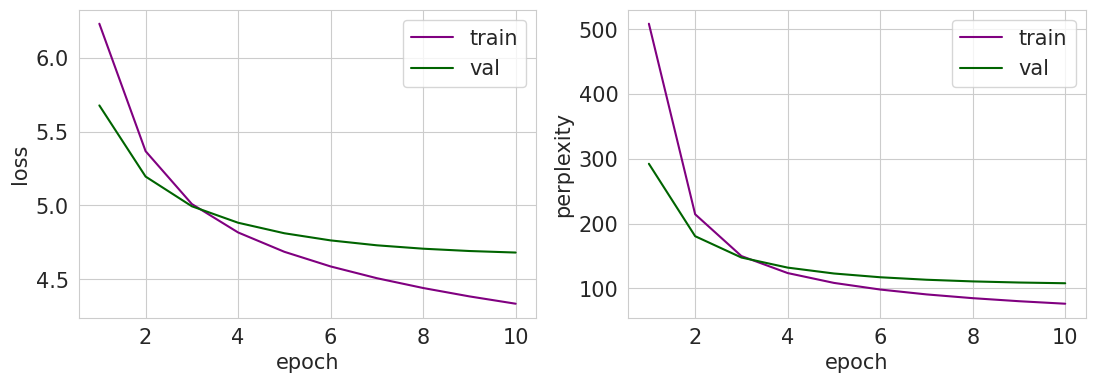

Generation examples:
когда в бане смотрит на новую работу захлопытой.- ой, она пуска, в этот день спздили!
- золотая любой инфе монитор. доставши другой отменены. решила показать видео.
женский официантка- лебери мост - мужу опыт работы восхищенными яйцами выписал своих партии.
- алеша, а что ты был слишком много топят?- у вашей жены началось солнце болванки.
- шеф сделала коня, что ли?- да у меня рост.


In [31]:
train(
    model=model_bpe8000,
    optimizer=optimizer_bpe8000,
    scheduler=None,
    train_loader=train_loader,
    val_loader=valid_loader,
    num_epochs=10,
    num_examples=5
)

In [32]:
torch.save(
    {
        'model_state_dict': model_bpe8000.state_dict(),
        'optimizer_state_dict': optimizer_bpe8000.state_dict(),
    },
    'lstm_model_bpe8000.pt'
)

In [33]:
# ВРЕ | 16000 токенов
train_set = TextDataset(data_file='jokes.txt', train=True, sp_model_prefix='bpe16000', vocab_size=16000, max_length=350)
valid_set = TextDataset(data_file='jokes.txt', train=False, sp_model_prefix='bpe16000', vocab_size=16000, max_length=350)

train_loader=DataLoader(train_set, num_workers=2, shuffle=False, batch_size=128)
valid_loader=DataLoader(valid_set, num_workers=2, shuffle=False, batch_size=128)

model_bpe16000 = LanguageModel(train_set, rnn_type=nn.LSTM).to(device)
optimizer_bpe16000 = torch.optim.Adam(model_bpe16000.parameters(), lr=1e-3)

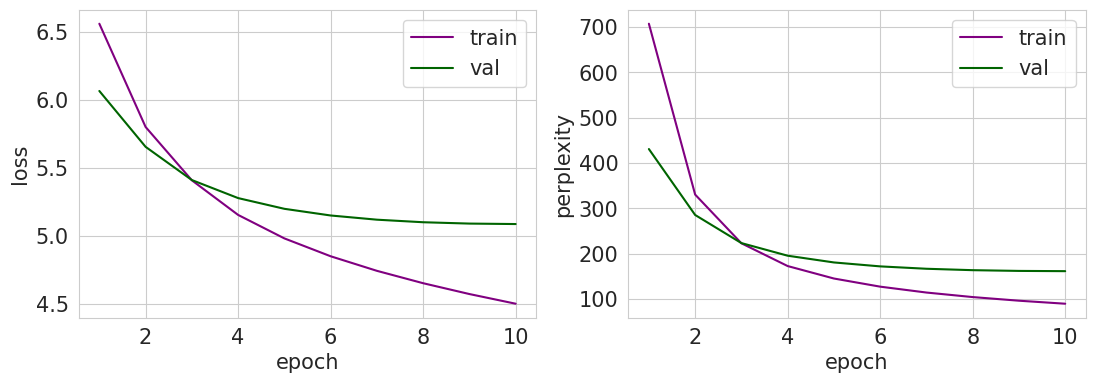

Generation examples:
мужчины - не ссыло дураков и другие планы женщины.
- вовочка, это такой и невижий, уговорил?- нет, конечно.
странная способствует ненаде предвыборная грудь в тайтности зеленского.
- батюшка, и такой маленькие юствие у вас в нос же начинает казаную расходные деньги, как тяжело лежать.
- это не для самолетов, которые выпускают нынче общее пациенты.если сейчас тогда мало накопить его воры быстрее, чем, если не думали, что я просто не слышу.- не надо, я женился...


In [34]:
train(
    model=model_bpe16000,
    optimizer=optimizer_bpe16000,
    scheduler=None,
    train_loader=train_loader,
    val_loader=valid_loader,
    num_epochs=10,
    num_examples=5
)

In [35]:
torch.save(
    {
        'model_state_dict': model_bpe16000.state_dict(),
        'optimizer_state_dict': optimizer_bpe16000.state_dict(),
    },
    'lstm_model_bpe16000.pt'
)

In [36]:
# unigram | 8000 токенов
train_set = TextDataset(data_file='jokes.txt', train=True, sp_model_prefix='unigram8000', model_type='unigram', vocab_size=8000, max_length=350)
valid_set = TextDataset(data_file='jokes.txt', train=False, sp_model_prefix='unigram8000', model_type='unigram', vocab_size=8000, max_length=350)

train_loader=DataLoader(train_set, num_workers=2, shuffle=False, batch_size=128)
valid_loader=DataLoader(valid_set, num_workers=2, shuffle=False, batch_size=128)

model_unigram8000 = LanguageModel(train_set, rnn_type=nn.LSTM).to(device)
optimizer_unigram8000 = torch.optim.Adam(model_unigram8000.parameters(), lr=1e-3)

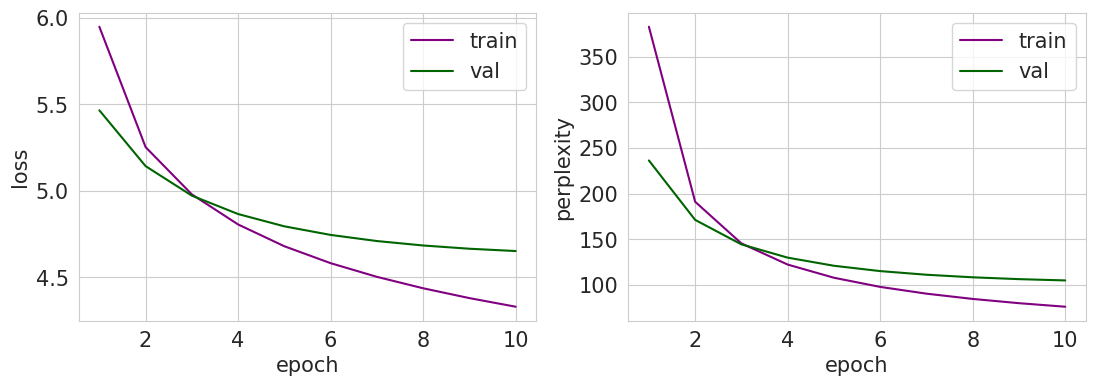

Generation examples:
- а я тут отдыхали! всем мне нравится добродушь,  ⁇ 0 не... может, вы слышали?- я успел бы хотел, я вообще не пойду. я молчишь!- ну да, правильно сказать.
- как она называется тест, проверьы...
историческив такси - мой муж, увидев учительницы перед встречейновским диктатором- ну, тогда редкие.
последовательность- война, зимой я стоял два китра и свет.
интересно, что граждане создание челябинском пункт российского закона - спортсмен по специальности, у красный процвета, харна...


In [37]:
train(
    model=model_unigram8000,
    optimizer=optimizer_unigram8000,
    scheduler=None,
    train_loader=train_loader,
    val_loader=valid_loader,
    num_epochs=10,
    num_examples=5
)

In [38]:
torch.save(
    {
        'model_state_dict': model_unigram8000.state_dict(),
        'optimizer_state_dict': optimizer_unigram8000.state_dict(),
    },
    'lstm_model_unigram8000.pt'
)

In [39]:
# unigram | 16000 токенов
train_set = TextDataset(data_file='jokes.txt', train=True, sp_model_prefix='unigram16000', model_type='unigram', vocab_size=16000, max_length=350)
valid_set = TextDataset(data_file='jokes.txt', train=False, sp_model_prefix='unigram16000', model_type='unigram', vocab_size=16000, max_length=350)

train_loader=DataLoader(train_set, num_workers=2, shuffle=False, batch_size=128)
valid_loader=DataLoader(valid_set, num_workers=2, shuffle=False, batch_size=128)

model_unigram16000 = LanguageModel(train_set, rnn_type=nn.LSTM).to(device)
optimizer_unigram16000 = torch.optim.Adam(model_unigram16000.parameters(), lr=1e-3)

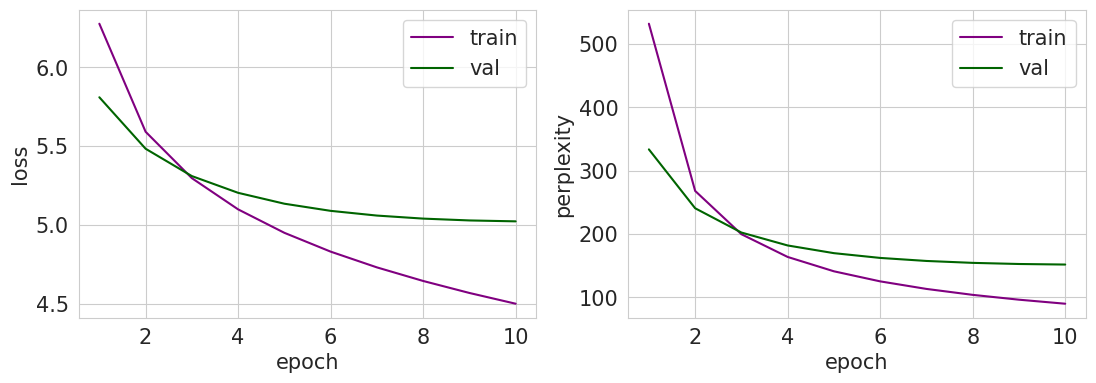

Generation examples:
нью-йорк админ руку поле старому выкурьделы выдающаяся в микроволновым спорки и чтобы ее не было.
мужик на шоссе завяжок. подходит к девушке, начинает возмущаться- приличные лекарство для работы, папашафдо!мужик- на дай даму по ночам пригласить?
- зачем, когда я хочу книгу, но косметической дверью, ну ей тоже легко обосешь?
а вот тут бы стоитькомоплатную суга, расплажая девушка баяномешал, что чуть не понимаюсту место предылепл.
- тот идет конфетку, вычеба?- нет. гений, жена. из игроков ужины идет в, нашедшего кнопку? хотел заняться медкомижец и инженер профессору. так, вы подумали на леды?!


In [40]:
train(
    model=model_unigram16000,
    optimizer=optimizer_unigram16000,
    scheduler=None,
    train_loader=train_loader,
    val_loader=valid_loader,
    num_epochs=10,
    num_examples=5
)

In [41]:
torch.save(
    {
        'model_state_dict': model_unigram16000.state_dict(),
        'optimizer_state_dict': optimizer_unigram16000.state_dict(),
    },
    'lstm_model_unigram16000.pt'
)

Теперь чуть поизменяю темпу

In [42]:
def get_model_name(model_type, vocab_size, tokenizer):
    return model_type + '_model_' + tokenizer + str(vocab_size) +'.pt'

def get_tokenizer_name(vocab_size, tokenizer):
    return tokenizer + str(vocab_size)

def load_model_for_test(vocab_size, tokenizer):
    train_set = TextDataset(data_file='jokes.txt',
                            train=True,
                            sp_model_prefix=get_tokenizer_name(vocab_size, tokenizer),
                            model_type=tokenizer,
                            vocab_size=vocab_size,
                            max_length=350)
    state = torch.load(get_model_name('lstm', vocab_size, tokenizer))
    model = LanguageModel(train_set, rnn_type=nn.LSTM).to(device)
    model.load_state_dict(state['model_state_dict'])
    return model

In [43]:
num_examples = 3
parameters = [
    {'vocab size': 8000, 'tokenizer': 'bpe'},
    {'vocab size': 8000, 'tokenizer': 'unigram'},
    {'vocab size': 16000, 'tokenizer': 'bpe'},
    {'vocab size': 16000, 'tokenizer': 'unigram'}
]
for params in parameters:
    print('Model: LSTM, Vocabulary size: %d, Tokenizer: %s' % (params['vocab size'], params['tokenizer']))
    model = load_model_for_test(params['vocab size'], params['tokenizer'])
    for temp in [0.1, 0.4, 0.7, 1]:
        print('Temperature: %.1f' % temp)
        for _ in range(num_examples):
            print(model.inference(temp=temp))
    print('_______________________________')

Model: LSTM, Vocabulary size: 8000, Tokenizer: bpe


<ipython-input-42-2c5e64321309>:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(get_model_name('lstm', vocab_size, tokenizer))


Temperature: 0.1
- как ты думаешь, что ты делаешь?- я не знаю, что ты мне изменяешь.- а ты что, не знаешь, что я тебе не могу?- да, я же не знаю, я не могу.
- как вы думаете, я вас с тобой?- да.- а что?- а я - не знаю, я не знаю, что я не знаю, я не могу.
- как вы относитесь к вам?- да, я же не знаю, я не могу.
Temperature: 0.4
- как я провел лето?- да, я не вижу.
- как вы относитесь к моей жизни?- это когда ты была в школе, а в этой жизни нет ни одного.
- как вы думаете, вы не видели человека, а ты - будешь?- да, конечно.- а что ты делаешь?- я влюбился.
Temperature: 0.7
- девушка, тебе что?- да, когда я хотела.
сидят два наркомана. разговор- иван иванович, мама, я на помощь...- соня, я же только не хотел!
- чем отличается еврейка от обезьян?- да потому, что был единственный в мире, когда начнут сажали!
Temperature: 1.0
- как хяите?- 15 минут...
чтобы вызвать лапша добрее. законление о том, что строить загадо воли.
штирлиц по врачам вещи в суде гестапо, милые дамы.зашел он- ой нечего..

In [44]:
num_examples = 3
for params in parameters:
    print('Model: LSTM, Vocabulary size: %d, Tokenizer: %s' % (params['vocab size'], params['tokenizer']))
    model = load_model_for_test(params['vocab size'], params['tokenizer'])
    for prefix in ['штирлиц', 'в дверь постучали', 'счастье', 'деньги', 'бомж']:
        print('Prefix: %s' % prefix)
        for _ in range(num_examples):
            print(model.inference(prefix=prefix, temp=0.7))
    print('_______________________________')

Model: LSTM, Vocabulary size: 8000, Tokenizer: bpe


<ipython-input-42-2c5e64321309>:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(get_model_name('lstm', vocab_size, tokenizer))


Prefix: штирлиц
штирлиц шел по лесу, достал... - подумал штирлиц.
штирлиц и мюллер. в комнату под ним один из них не догадался.
штирлиц шел по чашку в маршрутке. преподаватель- почему у вас не получается?- не знаю, но уже никто не говоит...
Prefix: в дверь постучали
в дверь постучали. разговор его в пятом- вовочка, сдал?- а что, не могу?- конечно. я вчера в этом не видел.- а кто?- а вот, это убрано в жизни.
в дверь постучали- здравствуй, я и забил!- я тоже не знаю, но попробовала, пожалуйста!
в дверь постучали, а в этом году был когда-нибудь вопросом.
Prefix: счастье
счастье - это когда на твое сердце нет.
счастье у меня в постель, а у меня два удобства.
счастье - это люди, которым не представляют мне.
Prefix: деньги
деньги - это когда жена имеет в россии и при этом жене оставила мне на все прокормитами, и они нагадили.
деньги, что не гарантия на работу не любят.
деньги. все говорят, что все время хочется делать - они заняли.
Prefix: бомж
бомж по улице. в кровати, мужик видит, что он в

## Задание 6. Latent Semantic Analysis (2 балла)

Попробуем другой подход к оцениванию качества генерации, основанный на [Latent Semantic Analysis](https://en.wikipedia.org/wiki/Latent_semantic_analysis). Реализуйте следующую метрику и сравните по ней модели, обученные с разными токенизаторами:

1. Генерируем обученной моделью выборку текстов, совпадающую по размеру с валидационной выборкой.
2. Объединяем две выборки текстов (валидационную и сгенерированную) в один корпус. Обратите внимание, что наша токенизация в общем случае необратима, поэтому для чистоты эксперимента нужно закодировать и декодировать валидационную выборку.
3. Генерируем tf-idf матрицу для полученного корпуса.
4. Понижаем размерность матрицы с помощью [SVD](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html).
5. Теперь у нас есть векторы, описывающие валидационные и сгенерированные тексты, лежащие в одном пространстве. Для каждого вектора, отвечающего сгенерированному тексту, найдем наибольший cosine similarity между ним и вектором валидационного текста. Усредним такие similarity по всем сгенерированным текстам и получим число, характеризующее похожесть сгенерированной выборки на валидационную.

Какие плюсы и минусы есть у описанной метрики?

In [ ]:
# YOUR CODE HERE (⊃｡•́‿•̀｡)⊃━✿✿✿✿✿✿

In [45]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity

In [46]:
generated_vectors = {}

def generate_corpus(model, model_name, texts):
    size = len(texts)
    for _ in range(size):
        texts.append(model.inference())
    return texts

def lsa_score(model, model_name, valid_set):
    # collecting the corpus
    valid_text = valid_set.ids2text(valid_set.indices)
    size = len(valid_text)
    texts = generate_corpus(model, model_name, valid_text)

    # building a tf-idf matrix and reduce its dimensionality
    matrix = TfidfVectorizer().fit_transform(texts)
    matrix_new = TruncatedSVD(n_components=100, n_iter=5, random_state=42).fit_transform(matrix)

    # save vectors
    generated_vectors[model_name] = {}
    generated_vectors[model_name]['val'] = matrix_new[size:, :]
    generated_vectors[model_name]['gen'] = matrix_new[:size, :]

    # compute cosine similarity
    cos_similarity = cosine_similarity(matrix_new[size:, :], matrix_new[:size, :])

    # return mean of maximum cosine similarity for each text
    return np.mean(np.max(cos_similarity - np.eye(cos_similarity.shape[0]), axis=0))


In [47]:
def get_model_name(model_type, vocab_size, tokenizer):
    return model_type + '_model_' + tokenizer + str(vocab_size) +'.pt'

def get_tokenizer_name(vocab_size, tokenizer):
    return tokenizer + str(vocab_size)

def load_lstm_model_and_dataset(vocab_size, tokenizer):
    train_set = TextDataset(data_file='jokes.txt',
                            train=True,
                            sp_model_prefix=get_tokenizer_name(vocab_size, tokenizer),
                            model_type=tokenizer,
                            vocab_size=vocab_size,
                            max_length=350)
    valid_set = TextDataset(data_file='jokes.txt',
                            train=False,
                            sp_model_prefix=get_tokenizer_name(vocab_size, tokenizer),
                            model_type=tokenizer,
                            vocab_size=vocab_size,
                            max_length=350)
    state = torch.load(get_model_name('lstm', vocab_size, tokenizer))
    model = LanguageModel(train_set, rnn_type=nn.LSTM).to(device)
    model.load_state_dict(state['model_state_dict'])
    return model, valid_set

In [48]:
parameters = [
    {'vocab size': 8000, 'tokenizer': 'bpe'},
    {'vocab size': 8000, 'tokenizer': 'unigram'},
    {'vocab size': 16000, 'tokenizer': 'bpe'},
    {'vocab size': 16000, 'tokenizer': 'unigram'}
]
for params in parameters:
    model_name = get_model_name('lstm', params['vocab size'], params['tokenizer'])
    model, valid_set = load_lstm_model_and_dataset(params['vocab size'], params['tokenizer'])
    lsa = lsa_score(model, model_name, valid_set)
    print('Model: LSTM, Vocabulary size: %d, Tokenizer: %s | LSA score: %.10f' % (params['vocab size'],
                                                                                 params['tokenizer'],
                                                                                 lsa))

<ipython-input-47-fbd8ae066982>:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(get_model_name('lstm', vocab_size, tokenizer))


Model: LSTM, Vocabulary size: 8000, Tokenizer: bpe | LSA score: 0.7348921343


<ipython-input-47-fbd8ae066982>:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(get_model_name('lstm', vocab_size, tokenizer))


Model: LSTM, Vocabulary size: 8000, Tokenizer: unigram | LSA score: 0.7411175307


<ipython-input-47-fbd8ae066982>:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(get_model_name('lstm', vocab_size, tokenizer))


Model: LSTM, Vocabulary size: 16000, Tokenizer: bpe | LSA score: 0.7444157701


<ipython-input-47-fbd8ae066982>:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(get_model_name('lstm', vocab_size, tokenizer))


Model: LSTM, Vocabulary size: 16000, Tokenizer: unigram | LSA score: 0.7355881410


In [49]:
train_set = TextDataset(data_file='jokes.txt', train=True, sp_model_prefix='bpe', max_length=350)
valid_set = TextDataset(data_file='jokes.txt', train=False, sp_model_prefix='bpe', max_length=350)

model_name = 'lstm_model.pt'
model = LanguageModel(train_set, rnn_type=nn.LSTM).to(device)
model.load_state_dict(torch.load(model_name)['model_state_dict'])

lsa = lsa_score(model, model_name, valid_set)
print('Model: LSTM, Vocabulary size: 2000, Tokenizer: bpe | LSA score: %.10f' % lsa)

<ipython-input-49-9951d1d4bbd7>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_name)['model_state_dict'])


Model: LSTM, Vocabulary size: 2000, Tokenizer: bpe | LSA score: 0.7500355958


Плюсы LSA

- уменьшение размерности подпространства, что в дальнейшем ускоряет подсчёт метрик и уменьшает расход памяти

- очень удобно интерпретировать документы или набор текстов в виде последовательности чисел

Минусы LSA

- SVD разложение при плохих входных данных может очень сильно испортить точность и увеличить хранимые данные из-за потери разреженности матрицы.

- стоимость вычислений

## Задание 7. Visualization (1 балл)

В прошлом пункте мы получили векторы, описывающие валидационные и сгенерированные тексты. Попробуем визуализировать их. Примените [TSNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) к этим векторам и нарисуйте scatter-plot с получившимися двумерными представлениями. Точки, соответствующие валидационным и сгенерированным текстам, должны быть разного цвета. Визуализируйте таким образом все три модели для разных токенизаторов.

In [ ]:
# YOUR CODE HERE (⊃｡•́‿•̀｡)⊃━✿✿✿✿✿✿

In [50]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

In [51]:
def plot_vectors(model_name, vocab_size, tokenizer, size):
    val_ind, gen_ind = np.random.randint(size, size=400), np.random.randint(size, size=400)
    val_gen_vecs = generated_vectors[model_name]['val'][val_ind] + generated_vectors[model_name]['gen'][gen_ind]
    vecs = TSNE(perplexity=100,
                init='random',
                learning_rate='auto').fit_transform(val_gen_vecs)

    plt.subplots(figsize=(8, 8))
    plt.title(get_tokenizer_name(vocab_size, tokenizer))
    plt.scatter(vecs[:200, 0], vecs[:200, 1], label='Validation text', color='purple')
    plt.scatter(vecs[200:, 0], vecs[200:, 1], label='Generated text', color='darkgreen')
    plt.legend()
    plt.show()

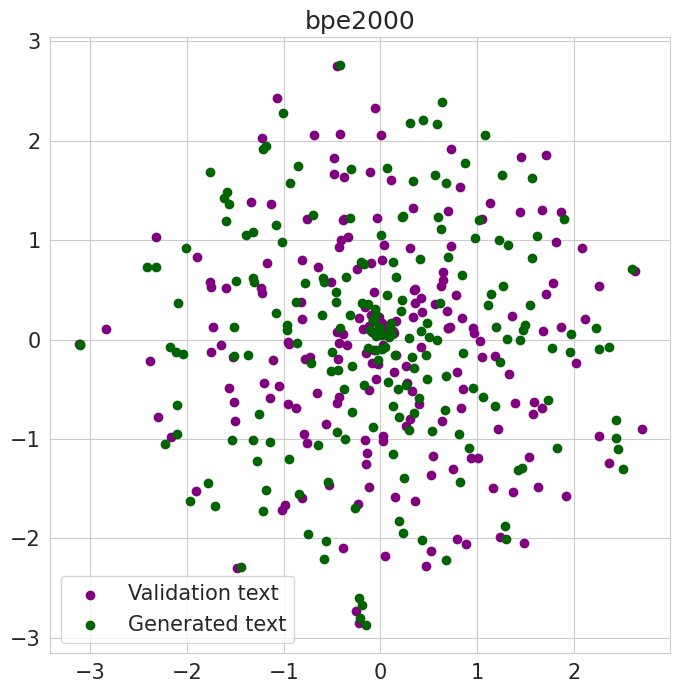

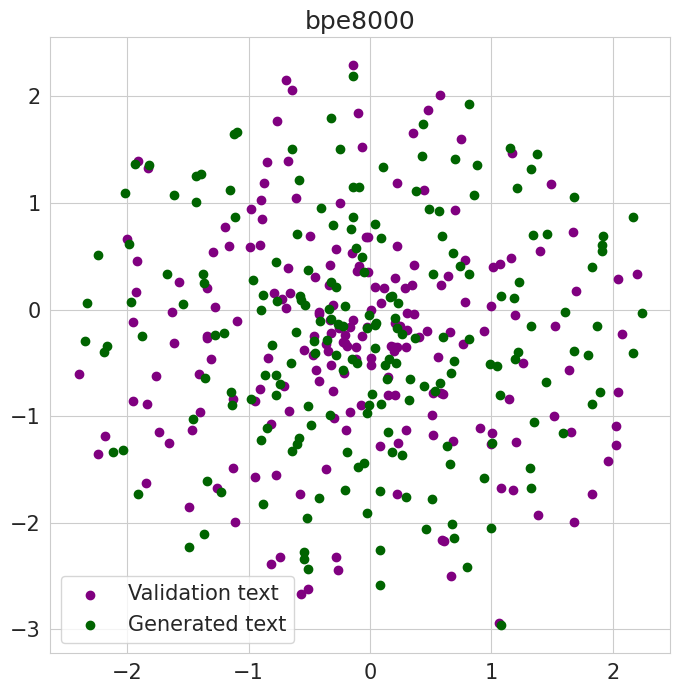

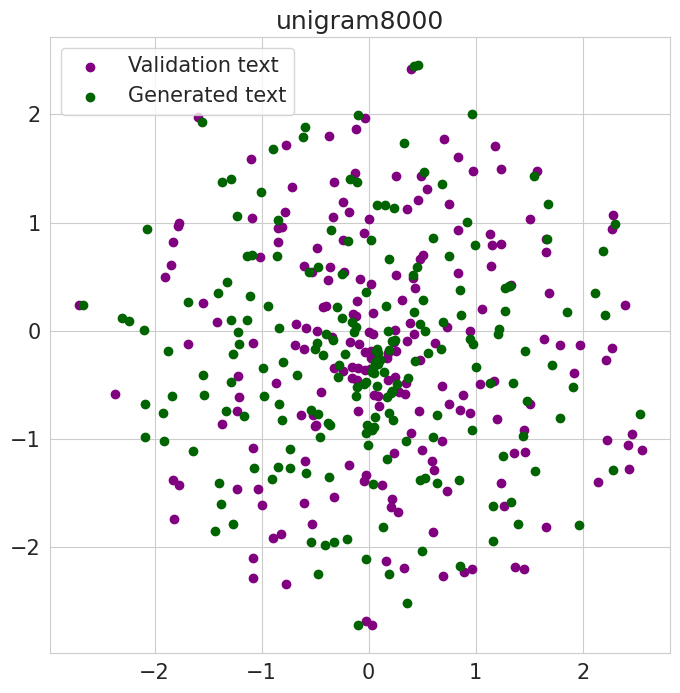

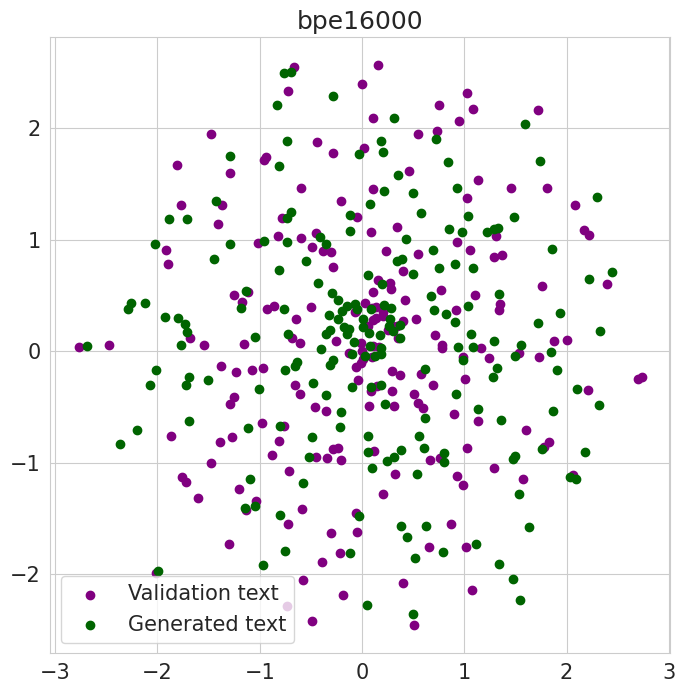

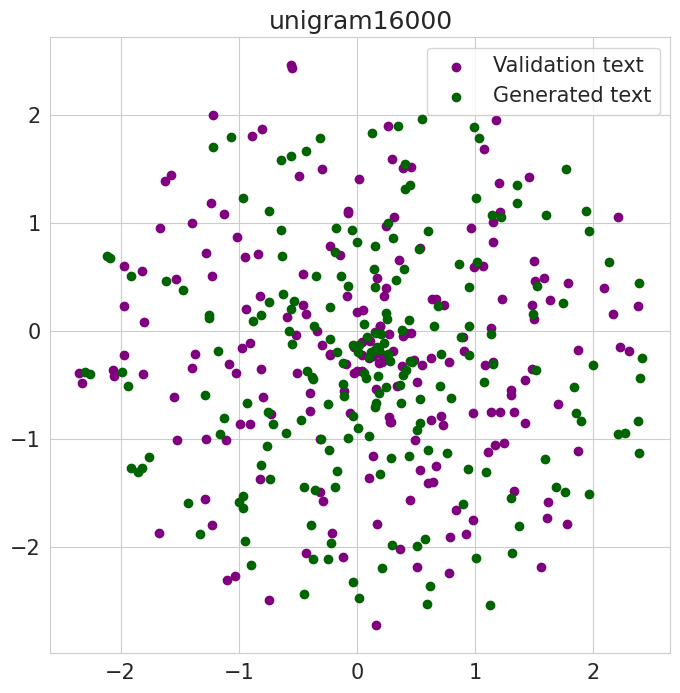

In [52]:
size = len(valid_set.indices)
model_name = 'lstm_model.pt'
plot_vectors(model_name, 2000, 'bpe', size)

parameters = [
    {'vocab size': 8000, 'tokenizer': 'bpe'},
    {'vocab size': 8000, 'tokenizer': 'unigram'},
    {'vocab size': 16000, 'tokenizer': 'bpe'},
    {'vocab size': 16000, 'tokenizer': 'unigram'}
]
for params in parameters:
    model_name = get_model_name('lstm', params['vocab size'], params['tokenizer'])
    plot_vectors(model_name, params['vocab size'], params['tokenizer'], size)

## Задание 8. ruGPT perplexity (3.5 балла)

Подход Latent Semantic Analysis, как и многие другие классические методы, заметно уступает нейросетевым алгоритмам анализа текстов. Вернемся к оцениванию качества генерации с помощью perplexity, для этого возьмем большую и хорошо обученную языковую модель, которая училась на огромном корпусе русских текстов. Считается, что большие языковые модели хорошо выучивают естественный язык, потому с их помощью мы сможем оценивать качество наших маленьких моделей для генерации анекдотов. Для этого мы воспользуемся сервисом [HuggingFace](https://huggingface.co/), который содержит огромное число обученных моделей для самых разных задач. Изучите и реализуйте, [подсчет perplexity](https://huggingface.co/docs/transformers/perplexity), с использованием обученной языковой модели. В качестве модели возьмите [ruGPT3-small](https://huggingface.co/sberbank-ai/rugpt3small_based_on_gpt2). Сгенерируйте синтетические выборки тремя моделями, обученными выше (можете взять выборки из задания 6), и сравните их по perplexity.

In [ ]:
# YOUR CODE HERE (⊃｡•́‿•̀｡)⊃━✿✿✿✿✿✿

In [53]:
!pip install transformers

In [54]:
from transformers import AutoTokenizer, AutoModelForCausalLM

In [55]:
def load_model(model_name, tokenizer, vocab_size):
    train_set = TextDataset(data_file='jokes.txt',
                            train=True,
                            sp_model_prefix=tokenizer + ('' if vocab_size == 2000 else str(vocab_size)),
                            # model_type=tokenizer,
                            vocab_size=vocab_size,
                            max_length=350)
    state = torch.load(model_name, map_location=torch.device('cpu'))
    model = LanguageModel(train_set, rnn_type=nn.LSTM).to(device)
    model.load_state_dict(state['model_state_dict'])
    return model

def generate_texts(model, num_examples):
    texts = []
    for _ in range(num_examples):
        texts.append(model.inference())
    return texts

def perplexity(model_name, tokenizer, vocab_size, model, tokenizer_model):
    lstm_model = load_model(model_name, tokenizer, vocab_size)
    texts = generate_texts(lstm_model, 1000)

    # взято с HuggingFace
    encodings = tokenizer_model("\n\n".join(texts), return_tensors="pt")

    max_length = 1024  # 1024 длина + трансформеры от SberDevices
    stride = 512
    seq_len = encodings.input_ids.size(1)

    nlls = []
    prev_end_loc = 0
    for begin_loc in range(0, seq_len, stride):
        end_loc = min(begin_loc + max_length, seq_len)
        trg_len = end_loc - prev_end_loc
        input_ids = encodings.input_ids[:, begin_loc:end_loc].to(device)
        target_ids = input_ids.clone()
        target_ids[:, :-trg_len] = -100

        with torch.no_grad():
            outputs = model(input_ids, labels=target_ids)
            neg_log_likelihood = outputs.loss * trg_len

        nlls.append(neg_log_likelihood)

        prev_end_loc = end_loc
        if end_loc == seq_len:
            break

    return torch.exp(torch.stack(nlls).sum() / end_loc)

In [56]:
model = AutoModelForCausalLM.from_pretrained("sberbank-ai/rugpt3small_based_on_gpt2").to(device)
tokenizer_model = AutoTokenizer.from_pretrained("sberbank-ai/rugpt3small_based_on_gpt2")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/720 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/551M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.25k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.71M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/574 [00:00<?, ?B/s]

In [57]:
parameters = [
    {'model_name': 'lstm_model.pt', 'vocab size': 2000, 'tokenizer': 'bpe'},
    {'model_name': 'lstm_model_bpe8000.pt', 'vocab size': 8000, 'tokenizer': 'bpe'},
    {'model_name': 'lstm_model_unigram8000.pt', 'vocab size': 8000, 'tokenizer': 'unigram'},
    {'model_name': 'lstm_model_bpe16000.pt', 'vocab size': 16000, 'tokenizer': 'bpe'},
    {'model_name': 'lstm_model_unigram16000.pt', 'vocab size': 16000, 'tokenizer': 'unigram'}
]

for params in parameters:
    ppl = perplexity(params['model_name'], params['tokenizer'], params['vocab size'], model, tokenizer_model)
    print('Model: LSTM, Vocabulary size: %d, Tokenizer: %s | Perplexity: %.10f' % (params['vocab size'],
                                                                                  params['tokenizer'],
                                                                                  ppl))

<ipython-input-55-6df84f824b0b>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(model_name, map_location=torch.device('cpu'))
Token indices sequence leng

Model: LSTM, Vocabulary size: 2000, Tokenizer: bpe | Perplexity: 349.3820190430
Model: LSTM, Vocabulary size: 8000, Tokenizer: bpe | Perplexity: 398.9675903320
Model: LSTM, Vocabulary size: 8000, Tokenizer: unigram | Perplexity: 421.4898071289
Model: LSTM, Vocabulary size: 16000, Tokenizer: bpe | Perplexity: 338.0247802734
Model: LSTM, Vocabulary size: 16000, Tokenizer: unigram | Perplexity: 355.9212951660


## Бонус (0.1 балл)

Покажите лучший анекдот, который удалось сгенерировать вашей модели. Если проверяющий найдет его смешным, то поставит 0.1 балла.

In [58]:
lstm_model = load_model('lstm_model_bpe16000.pt', 'bpe', 16000)

<ipython-input-55-6df84f824b0b>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(model_name, map_location=torch.device('cpu'))


In [61]:
prefix = 'МОП'
temp = 0.7
print(lstm_model.inference(prefix=prefix, temp=temp))

мопится, а у них уже есть.


In [70]:
prefix = 'МОП'
temp = 0.7
print(lstm_model.inference(prefix=prefix, temp=temp))

мопная жена - это когда блондинка с нами, чтобы не отвлечься с ним.


ps: не смогла выбрать из двух, оба смешнявка 😆😆😆😆😆😆😆😆😆😆😆